# Dyscalculia Gradient Module

1. Does the NPC have a different connectivity profile? /dispersion in connectivity space?
2. Differences in integration between networks that constitute NPC ? Between Network Dispersion
3. Connectivity differences due to specific task phase? PPI
4. Correlations with behavior?

Prerequisits:
All individual GMs (whole brain and only in NPC) must be fitted (in aligned version - to average GMs) and saved. This script loads them in and performs statistics on them; also for PPI, 1stLevel models already fit and saved in table 

In [13]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
from brainspace.gradient import GradientMaps
from numrisk.fmri_analysis.gradients.utils import get_basic_mask
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = op.join(bids_folder, 'plots_and_ims/gradient_stuff')

from os import listdir
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]
sub_array= np.array([int(i) for i in subList]) 

fsaverage = fetch_surf_fsaverage('fsaverage5') 

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()


## 1. NPC connectivity: only with itself  & to the whole brain

--> NPC-mask_gradient.ipynb / Dispersion&Eccentricity

test all combinations of 
1. cor_type = ['cm-subset', 'gm-subset']
2. n_grad = ['both 2D', 1, 2]

In [78]:
# within itself
cor_type =  'cm-subset'## 'covariance' # 
sparsity = '09'
spec = f'onlyNPC-{cor_type}' if  cor_type == 'covariance' else f'onlyNPC-{cor_type}_sparsity-{sparsity}'


In [39]:
# to the whole brain
cor_type = 'gm-subset'
spec = 'space-fsaverag5_n10'

from numrisk.fmri_analysis.gradients.utils_03 import get_nPRF_mask
nprf_r2_mask = get_nPRF_mask(bids_folder)

In [40]:
n_gradients = 5
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}

for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm, f'sub-{sub}_g-aligned_{spec}.npy'))
    if cor_type ==  'cm-subset' or cor_type == 'covariance':
        gm_aligned = gm_aligned.T
    elif cor_type == 'gm-subset':
        gm_aligned = gm_aligned[:, nprf_r2_mask]

    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

print(np.shape(gm_aligned))
print(np.shape(gms_aligned['g1']))


(10, 1510)
(66, 1510)


In [41]:
# 2D dispersion measure
n_grad = 'both 2D'
G_net = np.stack([np.array(gms_aligned['g1']).T, np.array(gms_aligned['g2']).T], axis=-1)  # shape: number of nodes in network x N x 2

centroid_cog_net = np.nanmedian(G_net, axis=0)  # shape: N x 2

# Compute the 2D Euclidean distance between each node and the centroid for each subject
dist_nodes_to_centroid = G_net - centroid_cog_net  # shape: number of nodes in network x N x 2
squared_distances = np.sum(dist_nodes_to_centroid**2, axis=-1)  # sum squares across 2D (last axis), shape: number of nodes in network x N

# Compute the within-network dispersion as the mean squared distance
NPC_2d_dispersion =  np.nanmean(squared_distances, axis=0)  # shape: N

df_npc = pd.DataFrame(NPC_2d_dispersion.T, index=sub_array, columns=['NPC_2D_dispersion'])
df_npc.index.name = 'subject'
df_npc = df_npc.join(group_list).set_index('group',append=True)
# df.to_csv(op.join(phenotype_folder, f'withinNdispersion-NPC_grad-{n_grad}.csv'))

In [42]:
# 1D
n_grad = 2
G1_net = np.array(gms_aligned[f'g{n_grad}']).T  # n_vertices x n_subjects

centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N

NPC_dispersion = np.nanmean((dist_nodes_to_centroid**2), axis = 0) 

df_npc = pd.DataFrame(np.array([NPC_dispersion, centroid_cog_net]).T, index=sub_array, columns=['NPC_dispersion', 'NPC_centroid'])
df_npc.index.name = 'subject'
df_npc = df_npc.join(group_list).set_index('group',append=True)
# df.to_csv(op.join(phenotype_folder, f'withinNdispersion-NPC_grad-{n_grad}.csv'))


TtestResult(statistic=-2.9144780891717263, pvalue=0.005211425490978965, df=52.92677544458943)


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


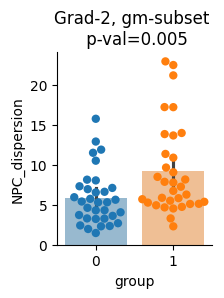

In [43]:
from scipy.stats import ttest_ind

y_var = 'NPC_2D_dispersion' if n_grad == 'both 2D' else 'NPC_dispersion' # #  'NPC_centroid' # 

tmp = df_npc.copy()

figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=y_var, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=y_var, size=6,legend=False)
stats = ttest_ind(tmp.xs(0,0,'group')[y_var], tmp.xs(1,0,'group')[y_var], axis=0, equal_var=False)
p_val = np.round(stats.pvalue,3)
print(stats)

n_grad = 'both 2D' if y_var == 'NPC_2D_dispersion' else n_grad
axes.set(title=f'Grad-{n_grad}, {cor_type} \n p-val={p_val}',ylabel=y_var, xlabel='group')
sns.despine()

## 2. Between network dispersion of nets constituting NPC

In [9]:
from numrisk.fmri_analysis.gradients.utils import get_glasser_parcels, get_glasser_CAatlas_mapping
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

from brainspace.utils.parcellation import map_to_labels
caNets_fsav5_mapping = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]


In [10]:
# load in gradients
spec = 'space-fsaverag5_n10'

n_gradients = 5
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}

for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm, f'sub-{sub}_g-aligned_{spec}.npy'))
    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

In [11]:
n_grad = 2 #'both 2D'

centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)
for n_network in np.unique(caNets_fsav5_mapping)[1:]:
    # Identify the nodes of the given Yeo network
    netNodes = np.where(caNets_fsav5_mapping == (n_network))[0]  # get (Glasser space) indices
    netNodes = np.squeeze(netNodes)

    if n_grad == 'both 2D':
        G1_net = np.array(gms_aligned['g1']).T[netNodes]  # shape: number of nodes in network x N
        G2_net = np.array(gms_aligned['g2']).T[netNodes]  # shape: number of nodes in network x N
        G_net = np.stack([G1_net, G2_net], axis=-1)  # shape: number of nodes in network x N x 2
    else:
        G_net = np.array(gms_aligned[f'g{n_grad}']).T[netNodes]

    centroid_cog_net = np.nanmedian(G_net, axis=0)  # shape: N x 2
    centroids_net.append(centroid_cog_net)

centroids_net = np.array(centroids_net)  # shape: N_nets x N_subs x 2 


In [14]:
from scipy.stats import ttest_ind
test_name = '2sample_TTest'

N_nets = 12
mat_pvals = np.ones([N_nets, N_nets])
mat_rs = np.zeros([N_nets, N_nets]) # = Tvals !

distances = []
net_name_comps = []
for n1 in range(N_nets):
    for n2 in range(n1, N_nets):
        #print(n1, n2)
        if n_grad == 'both 2D':
            distance = np.linalg.norm(centroids_net[n1] - centroids_net[n2], axis=1)
        else:
            distance = np.abs(centroids_net[n1] - centroids_net[n2]) # (12, 66)
        distances.append(distance)

        df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
        df.index.name = 'subject'
        df = df.join(group_list['group']).set_index('group',append=True)
        group_0 = df.xs(0, 0, 'group').values.flatten()  # Ensure 1D
        group_1 = df.xs(1, 0, 'group').values.flatten()  # Ensure 1D
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)

        mat_rs[n1, n2] = np.round(t_stat, 3)
        mat_pvals[n1, n2] = np.round(p_val, 4)

        net_name_comps.append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']))


Text(0.5, 1.1, '2sample_TTest between network distance \n grad-2')

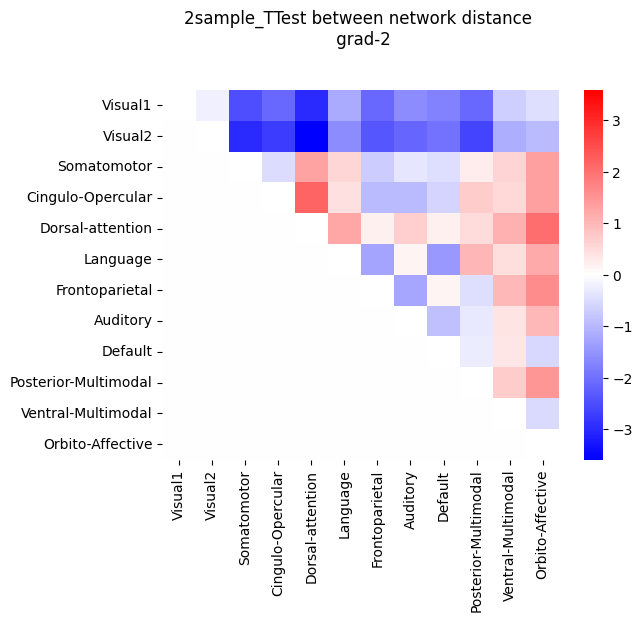

In [15]:
grad_name = '2D gradient space' if n_grad == 'both 2D' else f'grad-{n_grad}'

t_max = np.nanmax(np.abs(mat_rs.flatten())) 
sns.heatmap(mat_rs, cmap='bwr',vmin=-t_max,vmax=t_max,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'{test_name} between network distance \n {grad_name}', y=1.1)

In [16]:
# only multiple comparison over networks contained within NPC mask
network_labels = range(1, 13)
NPC_nets = [ 1,  2,  3,  4,  5,  7,  9, 10]
region_mask = np.isin(network_labels, NPC_nets)  # network_labels should match mat_pvals structure

mask = (mat_pvals != 1) & ~np.isnan(mat_pvals) & region_mask
pvals = mat_pvals[mask]
pvals = pvals[~np.isnan(pvals)]

from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Create a new matrix for corrected p-values
corrected_mat_pvals = np.full(mat_pvals.shape, np.nan)
mask = (mat_pvals != 1) & ~np.isnan(mat_pvals) & region_mask
corrected_mat_pvals[mask] = pvals_corrected

Text(0.5, 1.01, 'Corrected  P-vals \n 2sample_TTest - between network distance \n grad-2')

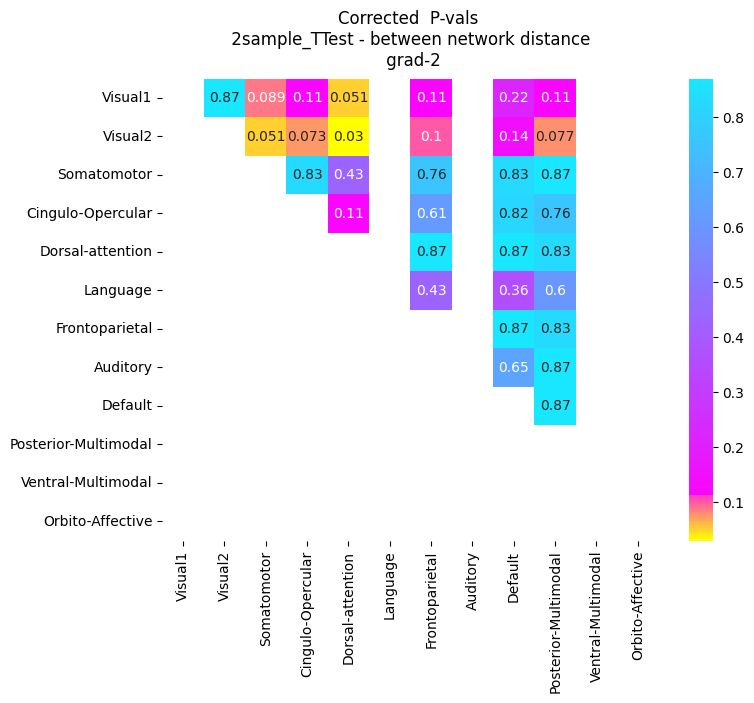

In [17]:
from numrisk.fmri_analysis.gradients.utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()

fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True

sns.heatmap(corrected_mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Corrected  P-vals \n {test_name} - between network distance \n {grad_name}', y=1.01)

TtestResult(statistic=-3.589397573596283, pvalue=0.0008558934261519203, df=42.25238571722055)


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


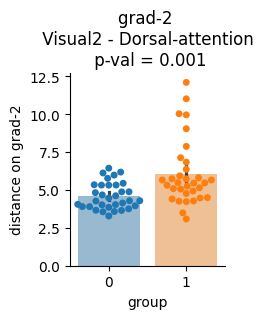

In [18]:
df_dist = pd.DataFrame(np.array(distances).T, index=sub_array, columns=net_name_comps)
df_dist.index.name = 'subject'
df_dist = df_dist.join(group_list).set_index('group',append=True)

net_comb = 'Visual2 - Dorsal-attention'
fig, axes = plt.subplots(1,1, figsize=(2,2.5)) # , sharex=True, sharey=True

sns.barplot(data=df_dist.reset_index(), x ='group', hue='group',y=net_comb, alpha=0.5,legend=False, ax=axes)
sns.swarmplot(data=df_dist.reset_index(),  x ='group', hue='group',y=net_comb, size=5,legend=False, ax=axes)

stats = ttest_ind(df_dist.xs(0,0,'group')[net_comb], df_dist.xs(1,0,'group')[net_comb], equal_var=False)  # Welch's t-test
p_val = np.round(stats.pvalue,3)
print(stats)

axes.set(title=f'{grad_name} \n {net_comb} \n p-val = {p_val}', ylabel='')
sns.despine()
axes.set(ylabel=f'distance on grad-{n_grad}')
fig.subplots_adjust(wspace=1)

In [36]:
net_comb = 'Visual2 - Dorsal-attention'

bnd_vis2_datt = df_dist[net_comb]

## 3. PPI
seedTS: nPRFs 

1stLevel model fits DataFrame created in `fmri_analysis/connectivity/ppi_2ndLevel.ipynb`

* Multiple comparison correction over all parcels
* ROI analysis (visual cortex - given previous findings)

In [22]:
psy_context1 = 'stimulus1_int'
psy_context2 = 'stimulus2_int'
regressors_names = ['seedTS', 'psy_context1', 'psy_context2', 'seedTS:psy_context1', 'seedTS:psy_context2']
formula = 'targetTS ~ ' + ' + '.join(regressors_names)

In [ ]:
# read in 1stLevel model fits DataFrame

stats_param = 'betas' # Tvals
thresh = 0.05
hemi = 'both'
seed_parcel_n = f'indnPRFs_hemi-{hemi}_thresh-{thresh}'

df_ppi = pd.read_csv(op.join(bids_folder, 'derivatives', 'ppi', f'ppi_{stats_param}-allSubsDF_seed-{seed_parcel_n}.csv'))
df_ppi.set_index(['subject','regressor','group'], inplace=True)


In [24]:
# Multiple comparison correction over all parcels

from statsmodels.stats.multitest import multipletests

print('FDR correction: Number of parcels surviving multiple comparison')
for param in regressors_names:
    #param = 'seedTS:psy_context1'
    tmp = df_ppi.xs(param,0,'regressor')
    group_0 = tmp.xs(0,0,'group')
    group_1 = tmp.xs(1,0,'group')

    t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)    
    corr_p_values = multipletests(p_values, method='fdr_bh')[1] #if correct_p_values else p_values # np.nan_to_num(p_values, nan=1, posinf=1, neginf=1)
    #name_spec = '_pvalFDRcorrected' if correct_p_values else ''
    print(f'{param}: N =  {np.sum(corr_p_values < 0.05)}')


FDR correction: Number of parcels surviving multiple comparison
seedTS: N =  0
psy_context1: N =  0
psy_context2: N =  0
seedTS:psy_context1: N =  0
seedTS:psy_context2: N =  0


TtestResult(statistic=2.3887294466969924, pvalue=0.019868259346559808, df=63.95797532801006)


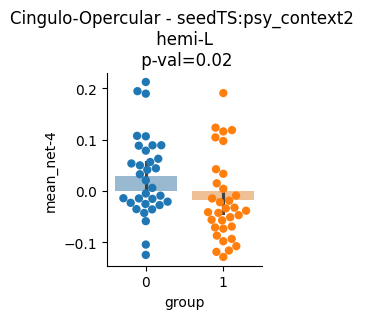

In [82]:
#  ROI analysis:

name_net =  'Cingulo-Opercular'# 'Visual1' #
hemi =  'L' # 'both' #'R' #'L' # 
param = 'seedTS:psy_context2'

n_net = np.where(CAatlas_names == name_net)[0][0] + 1
parcel_numbers = [(i+1) for i in np.where(glasser_CAatlas_mapping == n_net)[0]]
if hemi == 'L':
    parcel_numbers = [i for i in parcel_numbers if i < 181]
elif hemi == 'R':
    parcel_numbers = [i for i in parcel_numbers if i > 180]

columns_to_keep = [f'parcel_{i}' for i in parcel_numbers]
tmp = df_ppi.xs(param,0,'regressor')
tmp = tmp.filter(items=columns_to_keep)
tmp = pd.DataFrame(tmp.mean(axis=1), columns=[f'mean_net-{n_net}'])

from scipy.stats import ttest_ind
y_var = f'mean_net-{n_net}'

figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=y_var, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=y_var, size=6,legend=False)
stats = ttest_ind(tmp.xs(0,0,'group')[y_var], tmp.xs(1,0,'group')[y_var], axis=0, equal_var=False)
p_val = np.round(stats.pvalue,3)
print(stats)

axes.set(title=f'{name_net} - {param} \n hemi-{hemi} \n p-val={p_val}',ylabel=y_var, xlabel='group')
sns.despine()


In [83]:
ppi_df = tmp.copy()

In [ ]:
ppi_vis1_stim2 = tmp.copy()
ppi_vis1_stim2.rename(columns={f'mean_net-{n_net}': 'ppi_vis1_seedTSstim2'}, inplace=True)

## 4. Correlations with behavior



In [50]:
import statsmodels.api as sm

from numrisk.fmri_analysis.gradients.utils_02 import get_all_behavior
df_behav = get_all_behavior(bids_folder)#.join(group_list['age'], on='subject')

In [101]:
bnd_net_comb_param = 'Visual2 - Dorsal-attention'
npc_disp_param = 'NPC_dispersion'
ppi_param = 'ppi_vis1_seedTSstim2'
df_comb = df_behav.join(df_npc[npc_disp_param]).join(df_dist[bnd_net_comb_param]).join(ppi_vis1_stim2)


In [102]:
behav_vars = ['skill_score','memory_noise_sd','perceptual_noise_sd','gamma','erfassungsspanne','visio-spatial IQ','weber_frac']
neural_vars = [npc_disp_param, bnd_net_comb_param, ppi_param]

In [103]:
log_transform = False

ind_var =  'behaveVar' 
dep_var =  'neuralVar'
formula = f'{dep_var} ~ {ind_var} + group'

index = pd.MultiIndex.from_product([neural_vars, behav_vars, ['Intercept', ind_var, 'group']], 
                                   names=['NeuralVar', 'BehavVar', 'param'])
model_fits_df = pd.DataFrame(index=index, columns=['p_val', 'coef'])

for y_var in neural_vars:
    for x_var in behav_vars:
        df_comb['neuralVar'] = np.log(df_comb[y_var]) if log_transform else df_comb[y_var]
        df_comb['behaveVar'] = np.log(df_comb[x_var]) if log_transform else df_comb[x_var]
        result = sm.formula.ols(formula=formula, data=df_comb.reset_index()).fit()

        for param in ['Intercept', ind_var, 'group']: # 
            model_fits_df.loc[(y_var, x_var, param), 'p_val'] = result.pvalues.get(param, np.nan)
            model_fits_df.loc[(y_var, x_var, param), 'coef'] = result.params.get(param, np.nan)


In [59]:
import pandas as pd

# Set display options to show the entire DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [60]:
print(formula)
model_fits_df

neuralVar ~ behaveVar + group


p_val       coef
NeuralVar                  BehavVar            param                         
NPC_dispersion             skill_score         Intercept  0.000715   1.762288
                                               behaveVar  0.760824  -0.042885
                                               group      0.020955   0.414818
                           memory_noise_sd     Intercept  0.809483   0.476959
                                               behaveVar  0.565384  -0.560044
                                               group      0.129185   0.694408
                           perceptual_noise_sd Intercept  0.000003   1.714143
                                               behaveVar  0.756549    0.04191
                                               group      0.010538   0.482687
                           gamma               Intercept  0.000004   1.875791
                                               behaveVar  0.465709  -0.185642
                                               group      0.003393   0.432667
                           erfassungsspanne    Intercept  0.232326   1.154038
                                               behaveVar  0.630553   0.230037
                                               group      0.003644   0.482617
                           visio-spatial IQ    Intercept  0.338148   2.138829
                                               behaveVar  0.813365  -0.113643
                                               group      0.004279   0.436645
                           weber_frac          Intercept  0.000018   1.793028
                                               behaveVar  0.633043   0.102473
                                               group       0.00357   0.434281
Visual2 - Dorsal-attention skill_score         Intercept       0.0   1.755234
                                               behaveVar  0.265492   -0.07102
                                               group      0.021415   0.186243
                           memory_noise_sd     Intercept  0.220776   1.109252
                                               behaveVar  0.656412  -0.197217
                                               group      0.117953   0.325945
                           perceptual_noise_sd Intercept       0.0   1.768841
                                               behaveVar  0.074087   0.108466
                                               group      0.000124   0.332414
                           gamma               Intercept       0.0   1.859603
                                               behaveVar  0.029231  -0.248154
                                               group      0.000796   0.220204
                           erfassungsspanne    Intercept  0.000174   1.736484
                                               behaveVar  0.601957  -0.113443
                                               group      0.003452   0.220791
                           visio-spatial IQ    Intercept  0.116306   1.605463
                                               behaveVar  0.924519  -0.020745
                                               group      0.000773   0.236837
                           weber_frac          Intercept       0.0   1.648283
                                               behaveVar  0.415475   0.079348
                                               group      0.000794   0.229205
ppi_vis1_seedTSstim2       skill_score         Intercept  0.037952  -3.742763
                                               behaveVar  0.554491   0.295857
                                               group      0.289842  -0.573821
                           memory_noise_sd     Intercept  0.170213   -8.69705
                                               behaveVar  0.342029  -2.921377
                                               group      0.691923   0.582023
                           perceptual_noise_sd Intercept  0.018407  -3.345855
                                               behaveVar  0.639852  -0.253659
     

In [64]:
net_name_comps

['Visual1 - Visual1',
 'Visual1 - Visual2',
 'Visual1 - Somatomotor',
 'Visual1 - Cingulo-Opercular',
 'Visual1 - Dorsal-attention',
 'Visual1 - Language',
 'Visual1 - Frontoparietal',
 'Visual1 - Auditory',
 'Visual1 - Default',
 'Visual1 - Posterior-Multimodal',
 'Visual1 - Ventral-Multimodal',
 'Visual1 - Orbito-Affective',
 'Visual2 - Visual2',
 'Visual2 - Somatomotor',
 'Visual2 - Cingulo-Opercular',
 'Visual2 - Dorsal-attention',
 'Visual2 - Language',
 'Visual2 - Frontoparietal',
 'Visual2 - Auditory',
 'Visual2 - Default',
 'Visual2 - Posterior-Multimodal',
 'Visual2 - Ventral-Multimodal',
 'Visual2 - Orbito-Affective',
 'Somatomotor - Somatomotor',
 'Somatomotor - Cingulo-Opercular',
 'Somatomotor - Dorsal-attention',
 'Somatomotor - Language',
 'Somatomotor - Frontoparietal',
 'Somatomotor - Auditory',
 'Somatomotor - Default',
 'Somatomotor - Posterior-Multimodal',
 'Somatomotor - Ventral-Multimodal',
 'Somatomotor - Orbito-Affective',
 'Cingulo-Opercular - Cingulo-Opercular

In [69]:
bnd_net_comb_param = 'Visual2 - Dorsal-attention' # 'Visual2 - Cingulo-Opercular'#
df_comb = df_behav.join(df_dist[bnd_net_comb_param])

y_var = bnd_net_comb_param
x_var = 'gamma'

In [90]:
df_comb.columns


Index(['gamma', 'intercept', 'n1_slope', 'weber_frac', 'Percent Correct',
       'weber_frac_log', 'memory_noise_sd', 'perceptual_noise_sd',
       'basisscore', 'overall_score', 'erfassungsspanne',
       'memory_noise_sd_unbiased', 'perceptual_noise_sd_unbiased',
       'skill_score', 'visio-spatial IQ', 'verbal IQ', 'mean_iq', 'mean_net-4',
       'neuralVar', 'behaveVar'],
      dtype='object')

In [98]:
df_comb = df_behav.join(ppi_df)

y_var = 'mean_net-4'
x_var = 'erfassungsspanne'

In [99]:
log_transform = False
df_comb['neuralVar'] = np.log(df_comb[y_var]) if log_transform else df_comb[y_var]
df_comb['behaveVar'] = np.log(df_comb[x_var]) if log_transform else df_comb[x_var]
result = sm.formula.ols(formula=formula, data=df_comb.reset_index()).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              neuralVar   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     3.630
Date:                Tue, 04 Feb 2025   Prob (F-statistic):             0.0322
Time:                        15:07:39   Log-Likelihood:                 75.046
No. Observations:                  66   AIC:                            -144.1
Df Residuals:                      63   BIC:                            -137.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0583      0.072     -0.805      0.424      -0.203       0.086
behaveVar      0.0117      0.010      1.228      0.224      -0.007       0.031
group         -0.0338      0.022     -1.518      0.134      -0.078       0.011
==============================================================================
Omnibus:                        5.799   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.463
Skew:                           0.704   Prob(JB):                       0.0651
Kurtosis:                       3.052   Cond. No.                         54.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/tmp/ipykernel_2361303/2396812736.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r = cor['r'][0]
/tmp/ipykernel_2361303/2396812736.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val = cor['p-val'][0]


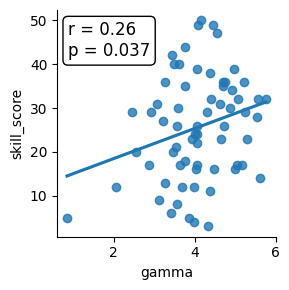

In [80]:
y_var = 'skill_score'
x_var = 'gamma'

import pingouin
cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'pearson') # does not hold with spearman or shepherd! --> outlier driven!
r = cor['r'][0]
p_val = cor['p-val'][0]

sns.lmplot(data=df_comb.reset_index(), x=x_var, y=y_var, ci=None, height=3, aspect=1)
plt.annotate(f'r = {r:.2f}\np = {p_val:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.show()

## ADDDitional

In [ ]:
sub_array = np.array([int(i) for i in subList])
dfs = []
for i in range(n_gradients):
    gradient_df = pd.DataFrame(gms_aligned[f'g{i+1}'], index=sub_array)
    gradient_df.index.name = 'subject'
    gradient_df = gradient_df.join(group_list).set_index('group', append=True)
    gradient_df['n_gradient'] = i + 1
    dfs.append(gradient_df.set_index('n_gradient', append=True))

df_gms = pd.concat(dfs).sort_index(level='n_gradient')

In [ ]:
# from other script... which gets group differences
n_gradients = 5
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}

for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm, f'sub-{sub}_g-aligned_{spec}.npy'))

    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

n_grad = 2
g1 = np.array(gms_aligned[f'g{n_grad}']).T # n_vertices x n_subjects

# get the gradient loadings of the nodes of the ROI, for each subject (shape: number of nodes in network x N)
G1_net = g1[nprf_r2_mask]

centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N

NPC_dispersion = np.nanmean((dist_nodes_to_centroid**2), axis = 0) 

df = pd.DataFrame(np.array([NPC_dispersion, centroid_cog_net]).T, index=sub_array, columns=['NPC_dispersion', 'NPC_centroid'])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)
# df.to_csv(op.join(phenotype_folder, f'withinNdispersion-NPC_grad-{n_grad}.csv'))
print(np.shape(G1_net))
G1_net